# Definição do 3º estágio líquido do MonteNegro
# Júlio César Rodrigues Machado - Mat: 2021033974

## Definições preliminares
 - Inclinação 98º

Uma inclinação de aproximadamente 98° é utilizada quando se quer uma órbita Heliossíncrona, que geralmente tem sua
altitude variando de 500 até 850 km. Como a intenção é maximizar a quantidade
de carga paga, será escolhida uma órbita de 500 km, inicialmente. Calculando-se o Delta V mínimo

## Velocidade orbital

Para atingir a velocidade orbital desejada para atingir a órbita de 500 km, é utilizada a seguinte equação:

$v = \sqrt(\mu\left(\frac{2}{r} - \frac{1}{a}\right))$, $r - R + H$

Onde: 

$v$ : velocidade orbital

$h$: altitude da órbita

$R$: Raio da terra: 6378.1 km

$\mu$: Parâmetro gravitacional da terra: 398600 km³/s²

Para órbitas circulares (a = r), que é o caso da órbita heliossíncrona, a equação fica: 

$v = \sqrt(\left(\frac{\mu}{r}\right))$
2

## DeltaV alvo

O DeltaV é um parâmetro energético, que serve para avaliar a capacidade que os foguetes
tem de transportar massa de um ponto a outro. Geralmente é calculado utilizando velocidades
orbitais e cálculos de transferência de órbita (ex: hofmann transfer).

Da literatura, para órbitas baixas (LEO), o deltaV é por volta de 8000 a 9400 m/s, com o dv target devendo estar 
próximo desses valores para mais ou para menos, além de necessariamente ser maior que 7800 m/s (velocidade orbital mínima).

O deltav V alvo necessário para se atingir a órbita circular será calculado a partir da análise de DV
obtida do curso de rocket propulsion do MIT como mostrado abaixo:
![Loss](imagens_doc/mit_deltva_calc_1.png)
![Loss](imagens_doc/mit_deltva_calc_2.png)

In [1]:
# minimal deltav velocity
import numpy as np
import matplotlib.pyplot as plt
def Min_deltaV_LEO(h):
    R_e = 6378.1  # km
    u = 398600  # km3/s2
    R = h + R_e
    n = R_e/R
    DV_min = np.sqrt(u/R_e)*(np.sqrt((2*((1-n)**2))/(1+n))+np.sqrt(n)) # km/s
    return DV_min*1000 # m/s

In [12]:
h = 900 # km, orbita minima to LEO
minimal_DV = Min_deltaV_LEO(h)
print("Delta V mínimo para LEO: {:.4f} m/s".format(minimal_DV))

Delta V mínimo para LEO: 8409.7438 m/s


### Gráfico extrapolando o cálculo para orbitas Circulares não LEO

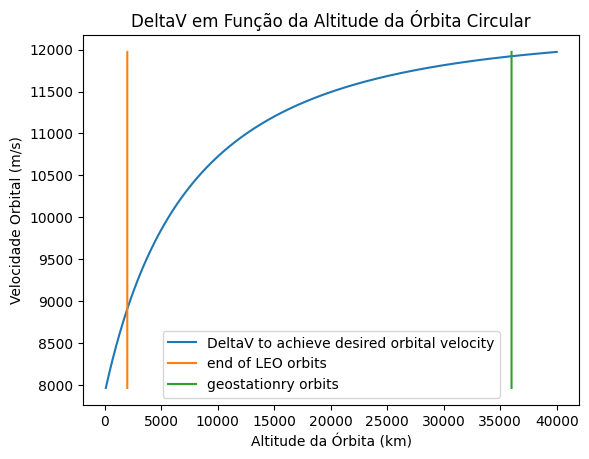

Text(0.5, 1.0, 'DeltaV em Função da Altitude da Órbita Circular')

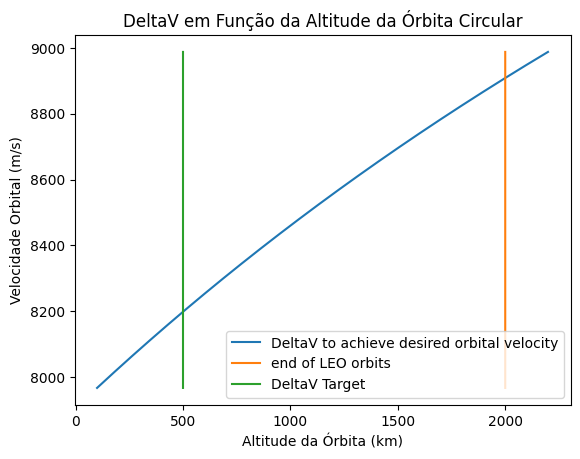

In [3]:
# grafico v_orbital orbita circular em função da altitude
orbita_circular_x = np.arange(100,40000)
orbita_circular_y = [ Min_deltaV_LEO(i) for i in orbita_circular_x]
leo_y = [ 2000 for i in orbita_circular_x]
geostationary_y = [ 36000 for i in orbita_circular_x]
plt.plot(orbita_circular_x,orbita_circular_y,label='DeltaV to achieve desired orbital velocity')
plt.plot(leo_y, orbita_circular_y,label='end of LEO orbits')
plt.plot(geostationary_y, orbita_circular_y,label='geostationry orbits')
plt.xlabel("Altitude da Órbita (km)")
plt.ylabel("Velocidade Orbital (m/s)")
plt.legend()
plt.title("DeltaV em Função da Altitude da Órbita Circular")
plt.show()
plt.close()
orbita_circular_x = np.arange(100,2200)
orbita_circular_y = [ Min_deltaV_LEO(i) for i in orbita_circular_x]
leo_y = [ 2000 for i in orbita_circular_x]
target_y = [ 500 for i in orbita_circular_x]
plt.plot(orbita_circular_x,orbita_circular_y,label='DeltaV to achieve desired orbital velocity')
plt.plot(leo_y, orbita_circular_y,label='end of LEO orbits')
plt.plot(target_y, orbita_circular_y,label='DeltaV Target')
plt.xlabel("Altitude da Órbita (km)")
plt.ylabel("Velocidade Orbital (m/s)")
plt.legend()
plt.title("DeltaV em Função da Altitude da Órbita Circular")

# DeltaV Evaluation Class
Now we have the target orbit, we need to evaluate the first two stages of the rocket, since 
that stages are completely defined. after the third stage will be considered.

To do that, the DeltaV classes was builded, that class calculates the stage DeltaV based on
propellant mass, isp, and dry mass (mass eficiency).


# Classe de Avaliação de DV

De modo a avaliar o dV para diferentes motores e em diferentes configurações, foi desenvolvida uma classe chamada deltaV.
Essa classe permite a configuração dos estágios de um foguete e o cálculo automático do dv associado a tal configuração, 
contando com a opção de considerar massas que serão alijadas em determinados estágios, como, por exemplo, a coifa que 
é descartada geralmente na queima do penúltimo/antepenúltimo estagio.
### métodos:

* add_stage: adiciona estagio - configuração (isp, mp, me, efic) e posição (de baixo para cima).
  Onde: mp-massa de propelente, me-massa da estrutura do estágio (dry mass), efic-eficiência máxima.
* remove_stage: remove estagio, informa-se a posição do mesmo.
* update_stage: atualiza estagio. Informa-se a nova configuração de (isp, mp, me, efic) e posição do estágio.
O método utiliza os métodos remove_stage e add_stage
* update_jettison_mass: atualiza a massa de alijamento (massa, posição do estágio onde é liberada)
* update_payload_mass: atualiza a carga paga
* show_up_stages: mostra a configuração de estágios posicionados ordenadamente (mp, me, isp)
* deltaV: calcula o deltaV do estágio da configuração de estágios informada.  
* get_optimum_prop_qtd: calcula a quantidade de propelente necessário a um dado estágio para que o foguete atinja
um DeltV fornecido como alvo.
* get_max_payload_mass: Quando o DeltaV da configuração de estágios é maior que o DeltaV fornecido como referência/alvo,
o método aumenta a carga paga até que DeltaV da configuração se iguale ou fique menor que o DeltaV alvo.

### Principais parâmetros: 
stages: lista dos estágios, ex: [[m prop, m estrutura, isp],[mesma coisa pro segundo estagio] ...]

jettison_mass: massa que vão ser alijadas (ex coifa) na forma [numero do estágio a ser alijada, massa a ser alijada], ex: 
[[2, massa1],[3,massa2], ex: massa coifa a ser alijada no segundo estágio: jettison_mass = [2, mcoifa]. Se for para ser
considerada até o final (ex: baterias) colocar 'n' no primeiro parâmetro da lista, ex(massa baterias): ['n', mbaterias] 

payload_mass: autoexplicativo, isp: autoexplicativo, deltav_reference/deltaV_target: autoexplicativo, 
position/stage_position: posição do estágio considerado, de baixo pra cima 
(exemplo número do estágios do vlm: [S50, S50, terceiro liquido] -> númeração: [1,2,3], 1: S50, 2: S50, 3: terceiro liquido

mp: massa do propelente, me: massa das estruturas (calculada a partir das eficiências mássicas ou servindo de base para o cálculo de tais eficiências. Massa dos tanques ou qualquer outra que varie com a quantidade de propelente), efic: eficiência mássica (mp/(mp+me)),


# A classe:

In [4]:
import numpy as np
import pandas as pd

class AnalysisOfDeltaV:
    def __init__(self, stages: list, jettison_mass: list = None, 
                 payload_mass: float = 0.0, name: str ='Rocket'):
        self.payload_mass = payload_mass # kg
        # stage configuration: [mp, me, isp] #kg, s
        self.stages = stages
        #[number of stage to jettison (nsj), mass] #kg
        # if not to be jettisoned, put 'n' in nsj parameter
        self.jettison_mass = jettison_mass
        self.g = 9.80665  # m/s²
        self.analysis_name = name

    @staticmethod
    def me_function(mp, efic): # structural mass from eficiency
        return mp / efic - mp

    @staticmethod
    def efic_m(mp, me): # eficiency from structural mass (me-massa estrutural)
        return mp/(mp+me)

    def deltaV(self, mpay=None): #calculo automatico de deltaV dos estagios
        stages = self.stages 
        jettison_mass = self.jettison_mass
        if mpay is None:
            mpay = self.payload_mass
        else:
            self.payload_mass = mpay

        dv = 0
        total_mass = 0
        me_i = 0
        me_f = 0
        if jettison_mass is None:
            pass
        else:
            for i in range(len(jettison_mass)):
                total_mass += jettison_mass[i][1]

        for i in range(len(stages)):  # variando estágios
            if jettison_mass is None:
                pass
            else:
                for k in range(len(jettison_mass)):  # avaliacao alijamento de massa
                    if isinstance(jettison_mass[k][0],int):
                        if i == jettison_mass[k][0] - 1:
                            me_i = total_mass
                            total_mass = total_mass - jettison_mass[k][1]
                            me_f = total_mass
                            break
                        else:
                            me_i = total_mass
                            me_f = total_mass

            mo = 0
            for j in range(i, len(stages)): # calculando massa inicial de cada passo
                mo = mo + stages[j][0] + stages[j][1]

            mf = 0
            for j in range(i, len(stages)): # calculando massa final de cada passo
                if j == i:
                    mf = mf + stages[j][1]
                else:
                    mf = mf + stages[j][0] + stages[j][1]

            dvl = self.g * stages[i][2] * np.log((mo + me_i + mpay) / (mf + me_f + mpay)) #dV
            dv = dv + dvl
        return dv

    def add_stage(self, isp, position='last', mp=0, me=0, efic=0): #adicionao estagio
        if (efic == 0) and (me == 0):
            print("me, efic: a least one must be informed. Stage not inserted")
            return
        elif me == 0:
            me = self.me_function(mp, efic)
            new_stage = [mp, me, isp]
            if position == 'last':
                self.stages.append(new_stage)
            elif isinstance(position, int):
                self.stages.insert(position, new_stage)
            else:
                print("Position parameter must be 'last' or int (number of stage, down to up)")
        elif efic == 0:
            new_stage = [mp, me, isp]
            if position == 'last':
                self.stages.append(new_stage)
                return
            elif isinstance(position, int):
                self.stages.insert(position-1, new_stage)
                return
            else:
                print("Position parameter must be 'last' or int (number of stage, down to up)")
                return

    def remove_stage(self, position='last'):
        if position == 'last':
            self.stages.pop(-1)
            return
        elif isinstance(position, int):
            self.stages.pop(position-1)
            return
        else:
            print("Position parameter must be 'last' or int (number of stage, down to up)")
            return

    def update_stage(self, position, isp, mp, me=0, efic=0):
        self.remove_stage(position=position)
        self.add_stage(position=position, isp=isp, mp=mp, me=me, efic=efic)

    def update_jettison_mass(self, jettison_mass: list):
        self.jettison_mass = jettison_mass

    def update_payload_mass(self, payload_mass: float):
        self.payload_mass = payload_mass

    def show_up_stages(self, delivery='no'):
        df = pd.DataFrame(self.stages, columns=['mp', 'me', 'isp'])
        print(30*'-*')
        print("Stages Configuration - {}".format(self.analysis_name))
        print(df)
        print(30*'-*')
        if delivery.lower() == 'yes':
            return df
        elif delivery.lower() == 'no':
            pass
        else:
            print("delivery option must be 'yes' or 'no'")

    def get_optimum_prop_qtd(self, deltaV_target: float, stage_position='last', efic: float = 0, 
                             mpay: float = None, max_prop: float = 10000, step=1):
        if mpay is None:
            pass
        else:
            self.payload_mass = mpay
        if stage_position.lower() == 'last':
            position = -1
        elif isinstance(stage_position, int):
            position = stage_position-1
        else:
            print("stage position must be 'last' or the number of stage.")
            return
        if efic == 0:
            efic = self.efic_m(self.stages[position][0], self.stages[position][1])

        self.stages[position][0] = 0
        self.stages[position][1] = self.me_function(self.stages[position][0], efic)
        dv = self.deltaV(mpay=self.payload_mass)
        x_mprop = [self.stages[position][0]]
        y_dv = [dv]
        y_dv_target = [deltaV_target]
        while dv < deltaV_target:
            self.stages[position][0] += step
            self.stages[position][1] = self.me_function(self.stages[position][0], efic)
            dv = self.deltaV()
            x_mprop.append(self.stages[position][0])
            y_dv.append(dv)
            y_dv_target.append(deltaV_target)
            if self.stages[position][0] > max_prop:
                break
        if dv > deltaV_target:
            print("DeltaV reached")
        else:
            print("DeltaV not reached")
        return self.stages[position][0], x_mprop, y_dv, y_dv_target

    def get_max_payload_mass(self, deltaV_reference: float, step=1):
        self.payload_mass = 0
        dv = self.deltaV()
        x_mpay = [self.payload_mass]
        y_dv = [dv]
        while dv > deltaV_reference:
            self.payload_mass += step
            dv = self.deltaV()
            x_mpay.append(self.payload_mass)
            y_dv.append(dv)
        return self.payload_mass, x_mpay, y_dv


# Calculando massa e eficiencia dos estágios
### Calculo baseado em ciclo, massa e tipo de propelente
diagrama dos estágios:
![Loss](ciclyes_diagram.jpg)

### Some considerations
To realize comparisons it is necessary to estimate the total mass of each feed system 
described in the previous section. To simplify this analysis, only the mass of the principal 
components of each system will be considered. That is, the masses of the plumbing system, the 
mounting system, the valves and the electronics controls will be assumed as negligible. 
The comparis t, deal with engines primarily intended to be 
applied in vehicles operating far above of the sea level, where the atmospheric pressure is very 
low. Therefore, in the following calculations the atmospheric pressure will be neglected.

## Classe de Calculo de Massa de cilcos e eficiencias estrurual

In [5]:
import numpy as np

# parameters : [of,p_c, rho_ox, rho_f
class CycleAnalysis:
    # ox_properties/fuel properties= [rho, Mmolar]
    # gas_properties = [GasP, Mmolar, Gamma, To]
    # ox / fuel tank = [tensao_esc, densidade]
    # gas tank = [tensao_esc, densidade]
    # tanks : [[gas_tank], [ox_tank], [fuel_tank]]

    def __init__(self,ox_properties, fuel_properties,
                 gas_properties,
                 gas_tank, ox_tank, fuel_tank,
                 of, Mprop, Pc) -> None:

        self.k_u = 1.2 # relacao de volume V_tanque = k_u * V_prop
        self.k_g = 1.05 # segurança, massa do gas
        self.k_tp = 1.05 # segurança tanque de propelente
        self.k_tg = 1.05 # segurança tanque do gas pressurizante

        self.Runi = 8.31441 # J/mol K
        self.of = of
        self.Pc = Pc

        if  ox_tank[2] is None:
            self.Ptanks = 1.8 * self.Pc
            self.k_p = self.Ptanks / self.Pc
            self.k_p_ox = self.k_p
        else:
            self.Ptank_ox = ox_tank[2]
            self.k_p_ox = self.Ptank_ox/self.Pc

        if fuel_tank[2] is None:
            self.Ptanks = 1.8 * self.Pc
            self.k_p = self.Ptanks / self.Pc
            self.k_p_fuel = self.k_p
        else:
            self.Ptank_fuel = fuel_tank[2]
            self.k_p_fuel = self.Ptank_ox / self.Pc

        self.Mprop = Mprop
        # propellant
        self.rho_ox = ox_properties[0]
        self.Mmolar_ox = ox_properties[1]
        self.rho_fuel = fuel_properties[0]
        self.Mmolar_fuel = fuel_properties[1]

        self.alpha_o = (self.of / self.rho_ox) * (1 / (1 + self.of))
        self.alpha_f = (1 / self.rho_fuel) * (1 / (1 + self.of))
        self.alpha = self.alpha_f + self.alpha_o
        # propellant volume
        self.V_ox = self.alpha_o*self.Mprop
        self.V_fuel = self.alpha_f*self.Mprop
        # tanks volume
        self.V_t_ox = self.k_u*self.V_ox
        self.V_t_fuel = self.k_u*self.V_fuel

        self.sigma_to = ox_tank[0]
        self.rho_to = ox_tank[1]

        self.sigma_tf = fuel_tank[0]
        self.rho_tf = fuel_tank[1]

        self.sigma_tgas = gas_tank[0]
        self.rho_tgas = gas_tank[1]

        # gas
        self.Pgas_o = gas_properties[0]
        self.Mmolar_gas = gas_properties[1]
        self.gas_gamma = gas_properties[2]
        self.gas_T = gas_properties[3]


    def Pressurizing_gas_mass(self):
        termo1 = self.k_g*self.k_p*self.k_u
        termo2 = self.gas_gamma*self.alpha * (self.Mmolar_gas/(self.Runi*self.gas_T))
        termo3 = (1 - self.k_p * (self.Pc / self.Pgas_o))
        termo4 = self.Mprop*self.Pc
        termo5 = termo4/termo3
        m_g = termo1*termo2*termo5
        return m_g
    
    def Pressurizing_gas_tank_mass(self):
        termo1 = ((3*self.rho_tgas)/(2*self.sigma_tgas))
        termo2 = self.k_tg*self.k_g*self.k_p*self.k_u
        termo3 = self.gas_gamma*self.alpha
        termo4 = self.Mprop*self.Pc
        termo5 = 1-self.k_p*(self.Pc/self.Pgas_o)
        m_tg = termo1*termo2*termo3*(termo4/termo5)
        return m_tg

    def Propellant_tank_mass(self, type_prop: "ox or fuel" = None):
        if type_prop == 'ox':
            rho_tp = self.rho_to
            sigma_tp = self.sigma_to
            alpha_p = self.alpha_o
            k_p = self.k_p_ox

        elif type_prop == 'fuel':
            rho_tp = self.rho_tf
            sigma_tp = self.sigma_tf
            alpha_p = self.alpha_f
            k_p = self.k_p_fuel
        else:
            print('erro')
            return
        m_tp = ((3*rho_tp)/(2*sigma_tp))*self.k_tp*k_p*self.k_u*alpha_p*self.Mprop*self.Pc
        return m_tp

    def Pressure_Fed_mass(self):
        mg = self.Pressurizing_gas_mass()
        mtg = self.Pressurizing_gas_tank_mass()
        mto = self.Propellant_tank_mass(type_prop='ox')
        mtf = self.Propellant_tank_mass(type_prop='fuel')
        return mg+mtg+mto+mtf
    
    def Efic_PressureFed(self):
        m_dry_stage = self.Pressure_Fed_mass()
        eficiencia = self.Mprop/(self.Mprop+m_dry_stage)
        return  m_dry_stage, eficiencia
    
    def Update_Mprop(self, Mprop):
        self.Mprop = Mprop

### função para avaliar se o deltaV foi alcançado

In [6]:
def eva_dv(dvtarget,dvcal):
    print(30*"*-")
    print(20*"*","AVALIAÇÃO DE DELTA-V",20*"*")
    if dvtarget <= dvcal:
        print("DeltaV alvo: {:.4f} m/s, DeltaV calculado: {:.4f} m/s".
              format(dvtarget,dvcal))
        print("Delta V alcançado")
    else:
        print("DeltaV alvo: {:.4f} m/s, DeltaV calculado: {:.4f} m/s".
              format(dvtarget,dvcal))
        print("Delta V não alcançado")
    print(30*"*-")

# Analise
A ideia é adicionar o terceiro estágio com ciclo pressurizante
com as configurações fornecidas acima, com uma massa de propelente inicial de 100 kg.

Então para a massa de propelente será calculada a massa estrutural, eficiência e o deltaV.

A massa de propelente será incrementada até que se atinga o delta V mínimo ou se chegue em um número máximo
de massa do estágio ( 1000 kg)

será estimado um isp de 300 s

# DELTA_V dos dois primeiros estágios

Abaixo estão os dados de dois motores s31 e o seu calculo de DV

Os dados foram retirados de Danton (2020).

In [13]:
# primeiro estagio - motor S31
isp1 = 260

mp1 = 670   #kg
me1 = 240 # kg
mest1 = mp1+me1 #kg

efim1 = mp1/(mp1+me1)
# configuração
MonteN_est1 = [mp1, me1, isp1]
MonteN_est2 = [mp1, me1, isp1]

### Massa da coifa e carga paga padrão
A massa da coifa é de 80 kg (Danton, 2020). Para a análise considera-se que a coifa é alijada ao final
da queima do segundo estágio.

Para a análise, a carga paga padrão inicial foi definida em 200 kg, o que parece razoável para uma órbita de 500 km. Por exemplo, o foguete tem electron tem a seguinte capacidade: 200 kg / 440 lbm To 500 km SSO

In [14]:
mpay = 1000
mcoifa = 80

## deltaV de apenas os dois primeiros estágio considerando coifa e carga util de 200 kg

In [15]:
jettison_mass = [[2, mcoifa]]

# inicialização da classe
# config de estagios VLM, carga paga e massas de alijamento
MonteNegro_2stages = AnalysisOfDeltaV(stages=[MonteN_est1, MonteN_est1],
                           jettison_mass=jettison_mass,
                           payload_mass=mpay,
                           name='MonteNegro_OnlyTwoStages')
# vizualizando estagios
MonteNegro_2stages.show_up_stages()

# calculando dv inicial
dv = MonteNegro_2stages.deltaV()
print("dv inicial: {:4f} m/s".format(dv))

#avaliando dv inicial
eva_dv(minimal_DV,dv)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Stages Configuration - MonteNegro_OnlyTwoStages
    mp   me  isp
0  670  240  260
1  670  240  260
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
dv inicial: 1875.918264 m/s
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
******************** AVALIAÇÃO DE DELTA-V ********************
DeltaV alvo: 8409.7438 m/s, DeltaV calculado: 1875.9183 m/s
Delta V não alcançado
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


# propriedades
Para o pressue fed o gas pressurizante escolhido foi o helio

o par propelente foi o oxido nitroso e o nitrometano

a pressao dos tanques ficou definida em 1.8 vezes a pressao do b

In [16]:
# PROPRIEDADES DE PROPELENTE
Mmolar_helio = 4.0026/1000 # kg/mol
T_helio = 288.15 # K
gamma_helio = 1.667 #
Pressao_Gas = 200*100000 # Pa (200 bar)
gas_properties = [Pressao_Gas, Mmolar_helio, gamma_helio, T_helio]
# oxidante - nitroso
ox_densi = 784 # kg/m³
ox_molar = 44.013*1000 # kg/mol
ox_properties = [ox_densi, ox_molar]
# combustivel - nitrometano
fuel_densi = 1140 # kg/m³
fuel_molar = 61.04*1000 # kg/mol
fuel_properties = [fuel_densi, fuel_molar]
# CALCULO DE MASSA DE TANQUES 
# oxidante
UTS_o = 455*1000000 # Pa
densi_t_o = 2800 # aluminiuim alloy
Pressao_oxt = 56*100000 # pressao no tanque
ox_tank = [UTS_o, densi_t_o, Pressao_oxt]

# combustivel
UTS_f = 455*1000000 # Pa
densi_t_f = 2800 # aluminium alloy
fuel_tank = [UTS_f, densi_t_f, None]
# gas
UTS_g = 3300*1000000 # Pa
densi_t_g = 1700 # kg/m³, kevlar
gas_tank = [UTS_g, densi_t_g]
# ENGINE PARAMETERS
Pc = 30*100000 # Pa
Mprop = 10 # Kg
of = 1.082

eficiencia:  1.1144735722904424 kg
mprop:  10 kg
0.8997277230413374
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Stages Configuration - MonteNegro_OnlyTwoStages
    mp          me  isp
0  670  240.000000  260
1  670  240.000000  260
2   10    1.114474  300
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
******************** AVALIAÇÃO DE DELTA-V ********************
DeltaV alvo: 8409.7438 m/s, DeltaV calculado: 1893.6855 m/s
Delta V não alcançado
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
******************** AVALIAÇÃO DE DELTA-V ********************
DeltaV alvo: 8409.7438 m/s, DeltaV calculado: 8410.2026 m/s
Delta V alcançado
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Stages Configuration - MonteNegro_OnlyTwoStages
    mp          me  isp
0  

Text(0, 0.5, 'dv (m/s)')

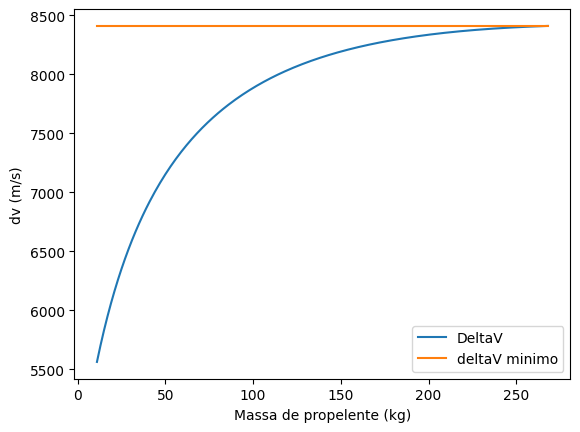

In [17]:
PressureFedCycle = CycleAnalysis(ox_properties=ox_properties,
                      fuel_properties=fuel_properties,
                      gas_properties=gas_properties,
                      gas_tank=gas_tank,
                      ox_tank=ox_tank,
                      fuel_tank=fuel_tank,
                      of=of,
                      Mprop=Mprop,
                      Pc=Pc,
                      )

me3, efi = PressureFedCycle.Efic_PressureFed()
print('eficiencia: ', me3,'kg')
print('mprop: ',Mprop,'kg')
print(efi)

isp3 = 300 # s
terceiroestagio = [Mprop, me3, isp3]

MonteNegro_2stages.add_stage(isp=isp3, position='last', mp=Mprop, me=me3, efic=0)
MonteNegro_2stages.show_up_stages()

dv = MonteNegro_2stages.deltaV()
eva_dv(minimal_DV,dv)

mpropx = []
dvy = []
efi_vetor = []
while dv < minimal_DV:
    mpay = mpay - 0.5
    Mprop = 10
    PressureFedCycle.Update_Mprop(Mprop=Mprop)
    me3, efi = PressureFedCycle.Efic_PressureFed()
    MonteNegro_2stages.update_stage(position='last', isp=300, mp=Mprop, me=me3, efic=0)
    MonteNegro_2stages.update_payload_mass(payload_mass=mpay)
    mpropx = []
    dvy = []
    efi_vetor = []
    dv = MonteNegro_2stages.deltaV()
    while dv < minimal_DV:
        Mprop += 1
        mpropx.append(Mprop)
        PressureFedCycle.Update_Mprop(Mprop=Mprop)
        me3, efi = PressureFedCycle.Efic_PressureFed()
        MonteNegro_2stages.update_stage(position='last', isp=300, mp=Mprop, me=me3, efic=0)
        dv = MonteNegro_2stages.deltaV()
        dvy.append(dv)
        efi_vetor.append(efi)
        if Mprop+me3 > 1000:
            break
    if mpay <= 0:
        break

eva_dv(minimal_DV,dv)
MonteNegro_2stages.show_up_stages()
print("Carga paga: {:.2f} kg".format(mpay))
minimum_dv = [minimal_DV for i in mpropx]
plt.plot(mpropx,dvy,label='DeltaV')
plt.plot(mpropx,minimum_dv,label='deltaV minimo')
plt.legend()
plt.xlabel('Massa de propelente (kg)')
plt.ylabel('dv (m/s)')

# resultado

eficiencia: 0.89

massa de propelente: 200 kg

carga util: 25 kg

Text(0, 0.5, 'dv (m/s)')

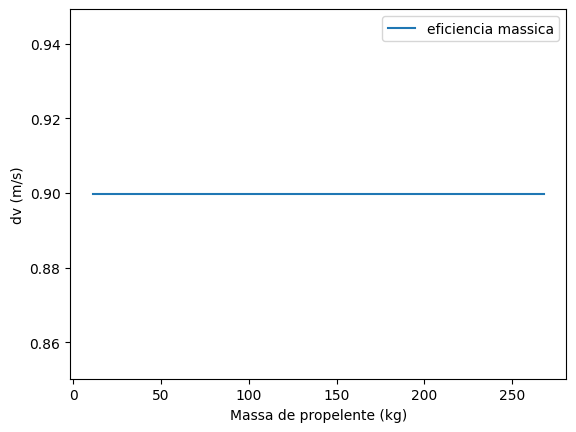

In [18]:
plt.plot(mpropx,efi_vetor,label='eficiencia massica')
plt.legend()
plt.xlabel('Massa de propelente (kg)')
plt.ylabel('dv (m/s)')